In [1]:
import pandas as pd
import numpy as np
from PyNM import PyNM
import seaborn as sns
import matplotlib.pyplot as plt

import patsy as pat
import statsmodels.api as sm

## **Generate multisite data**
### Randomize metadata for each site cohort

In [2]:
np.random.seed(666)
n_sites = 5
age_min = (np.random.rand(n_sites)*50).astype(int)
sites = pd.DataFrame(data={'sex_ratio': np.random.rand(n_sites),
                           'prob_ratio': 0.5*np.random.rand(n_sites),
                           'age_min': age_min,
                           'age_max': (age_min+5+np.random.rand(n_sites)*50).astype(int),
                           'score_shift': np.random.randn(n_sites)/4,
                           'sample_size': (50+np.random.rand(n_sites)*500).astype(int)})
sites

,sex_ratio,prob_ratio,age_min,age_max,score_shift,sample_size
0,0.012703,0.100124,35,78,-0.272198,494
1,0.413588,0.372077,42,47,-0.143943,363
2,0.048813,0.096446,33,43,-0.420725,459
3,0.099929,0.350422,36,46,0.057296,323
4,0.508066,0.146614,47,64,-0.439156,258


### Define implicit models

In [3]:
def model(age,sex,offset):
    noise = np.random.normal(0,0.1)
    return 0.001*age-0.00001*(age-50)**2+0.5 + noise - np.random.uniform(0,0.3)*sex + offset

#Same model for probands, w/ more extreme noise and small random shift down
def model_prob(age,sex,offset):
    noise = np.random.normal(0,0.1)
    return 0.001*age-0.00001*(age-50)**2+0.5 + noise - np.random.uniform(0,0.3)*sex -0.2*np.random.uniform() + offset

### Generate fake participant data

In [4]:
participants = []
for site in sites.iterrows():
    print(f'Processing site # {site[0]}')
    for participant in range(int(site[1]['sample_size'])):
        #sex = np.random.rand()>site[1]['sex_ratio']
        sex = np.random.binomial(1,site[1]['sex_ratio'])
        prob = np.random.binomial(1,site[1]['prob_ratio'])
        #age = site[1]['age_min'] + np.random.rand() * (site[1]['age_max']-site[1]['age_min'])
        age = np.random.uniform(site[1]['age_min'],site[1]['age_max'])
        if prob:
            score = model_prob(age,sex,site[1]['score_shift'])
        else:
            score = model(age,sex,site[1]['score_shift'])
        participants.append([site[0], sex,prob, age, score])

Processing site # 0
Processing site # 1
Processing site # 2
Processing site # 3
Processing site # 4


In [5]:
df=pd.DataFrame(participants, columns=['site', 'sex','group', 'age', 'score'])
df.sex.replace({1: 'Female', 0: 'Male'}, inplace=True)
df.group.replace({1: 'PROB', 0: 'CTR'}, inplace=True)
df

,site,sex,group,age,score
0,0,Male,CTR,38.232161,0.349112
1,0,Male,CTR,55.931562,0.313037
2,0,Male,CTR,73.802357,0.264671
3,0,Male,CTR,35.697482,0.162974
4,0,Male,CTR,53.062359,0.145542
...,...,...,...,...,...
1892,4,Female,CTR,53.846953,0.020551
1893,4,Male,CTR,57.198815,0.145518
1894,4,Female,CTR,59.868655,0.039627
1895,4,Female,CTR,57.605293,0.094016


## **Visualize data**
### By site

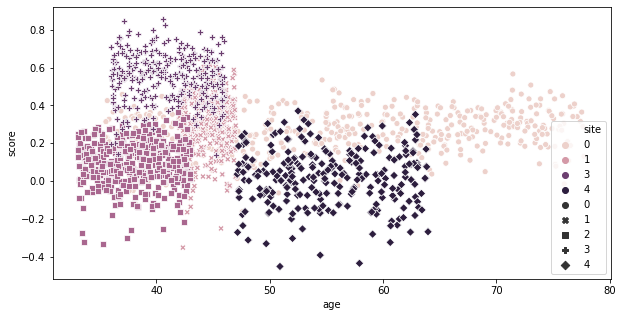

In [6]:
plt.figure(figsize=(10,5))
sns.scatterplot(data=df, x='age', y='score', hue='site', style='site')
plt.show()

### By PROB vs CTR

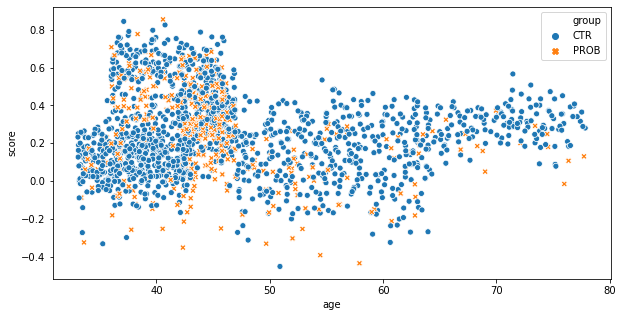

In [7]:
plt.figure(figsize=(10,5))
sns.scatterplot(data=df, x='age', y='score', hue='group', style='group')
plt.show()

## **PyNM - Normative Modeling**

In [8]:
#Initialize pynm w/ data and confounds
pynm = PyNM(df,'score','group',
            conf = 'age',                           #age confound for LOESS and Centiles model
            confounds = ['age','C(sex)','C(site)']) #multivarite confounds for GP model

#Initialize bins for LOESS and Centiles models
x, xcount, z, zm, zstd, zci = pynm.create_bins()

### Description of the **create_bins** output:
- **x**: age bins
- **xcount**: number of CTR participants (per bin)
- **z**: estimated centiles (per bin)
- **zm**: estimated mean (per bin)
- **zstd**: estimated standard deviation (per bin)
- **zci**: 95% confidence interval (per bin)

In [9]:
#Run models
loess = pynm.loess_normative_model()
centiles = pynm.centiles_normative_model()
gp = pynm.gp_normative_model() #multivariate confounds GP

#Collect output
data = pynm.data

Create another pynm object with only age confound (instead of multivariate confounds) to compare w/ centiles model

In [10]:
pynm_age_gp = PyNM(df,'score',confounds=['age'])
pynm_age_gp.gp_normative_model()
data_age_gp = pynm_age_gp.data

## **Visualize Normative Models**
### Centiles model

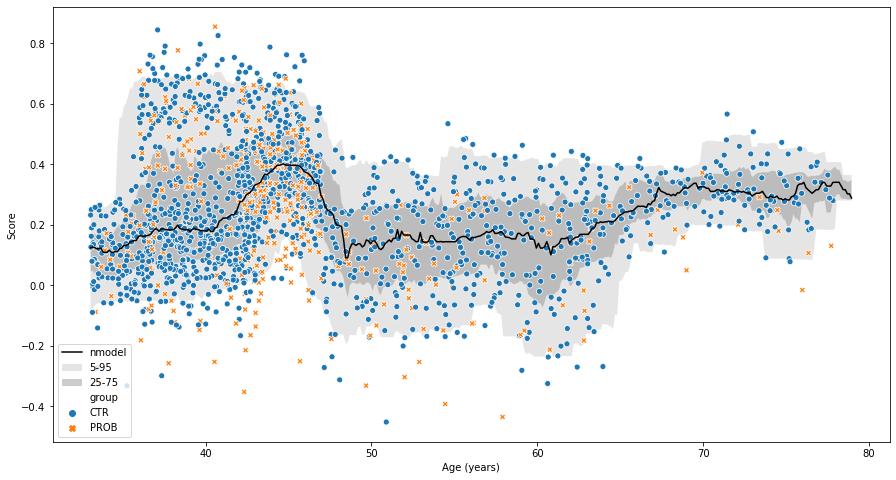

In [11]:
plt.figure(figsize=(15,8))

#Plot centiles
plt.fill_between(x,z[:, 5],z[:, 95],facecolor='grey',alpha=0.2,label='5-95')#,zorder=1)
plt.fill_between(x,z[:, 25],z[:, 75],facecolor='grey',alpha=0.4,label='25-75')#,zorder=2)

#Plot participants
sns.scatterplot(x = 'age',y='score',data=data, hue='group',style='group')

plt.plot(x, z[:, 50], '-', color='black',label='nmodel')

#Plot bins with less than 20 participants
for bin_sel in np.argwhere((xcount <= 20) + (xcount <= 20)).flatten():
    plt.plot(np.array([x[bin_sel], x[bin_sel]]),
                [z.min() - 1, z.max() + 1], '--k', alpha=0.5,color='red')

plt.ylabel('Score')
plt.xlabel('Age (years)')
#plt.ylim(-0.6,1)
plt.legend(loc='lower left')
plt.show()

### Gaussian Process model (age confound only)

Text(0.5, 1.0, 'Fake site data')

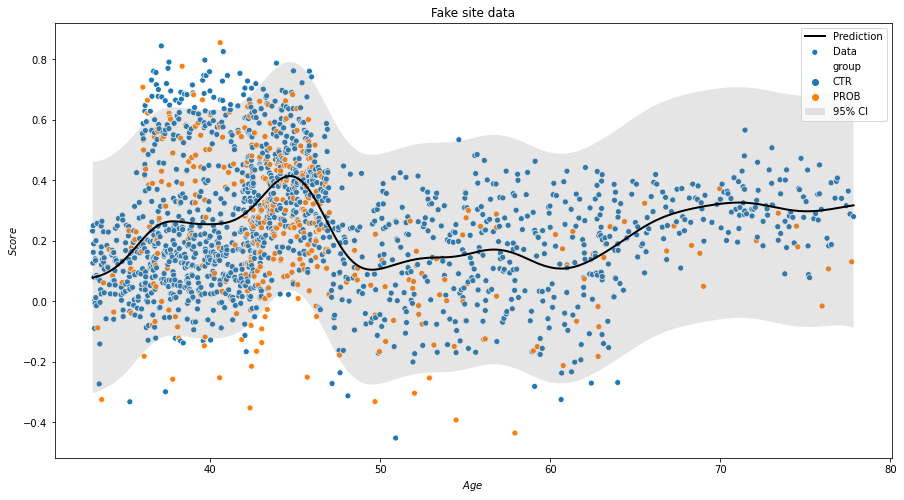

In [12]:
data_age_gp.sort_values('age',inplace=True)

plt.figure(figsize=(15,8))
sns.scatterplot(data=data_age_gp,x='age', y='score', label='Data',hue='group')
plt.plot(data_age_gp.age, data_age_gp.GP_nmodel_pred, color='black', label='Prediction',lw=2)
plt.fill_between(np.squeeze(data_age_gp.age),np.squeeze(data_age_gp.GP_nmodel_pred) - 2*data_age_gp.GP_nmodel_sigma,np.squeeze(data_age_gp.GP_nmodel_pred) + 2*data_age_gp.GP_nmodel_sigma,alpha=.2, fc='grey', ec='None', label='95% CI')

plt.xlabel('$Age$')
plt.ylabel('$Score$')
plt.legend(loc='upper right')
plt.title('Fake site data')

### Centiles vs. LOESS model scores

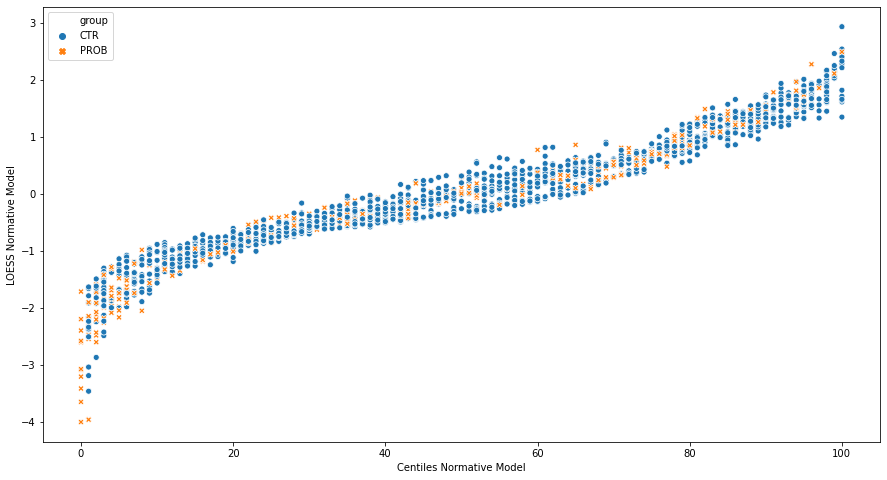

In [13]:
plt.figure(figsize=(15,8))
sns.scatterplot(x = 'Centiles_nmodel',y='LOESS_nmodel',data=data, hue='group',style='group')
plt.xlabel('Centiles Normative Model')
plt.ylabel('LOESS Normative Model')
plt.show()

### Centiles Model scores PROB vs CTR

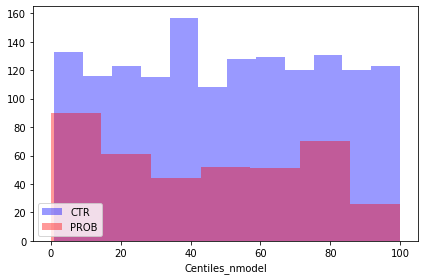

In [14]:
plt.figure()
fig = sns.distplot(data.loc[data.group == 'CTR', 'Centiles_nmodel'],color="blue", kde=False,label='CTR')
fig = sns.distplot(data.loc[data.group == 'PROB', 'Centiles_nmodel'],color="red", kde=False,label='PROB')
plt.tight_layout()
plt.legend(loc='lower left')
plt.show()

## **Including multiple confounds**
The GP model includes site, sex and age as a confounds. As a result its scores are centered around zero across sites. The other models (including only age as a confound) have a clear site effect in the scores.

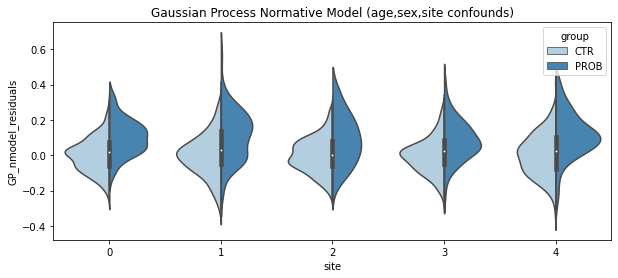

In [15]:
plt.figure(figsize=(10,4))
sns.violinplot(x='site',y='GP_nmodel_residuals',data=data,split=True,palette='Blues',hue='group')
plt.title('Gaussian Process Normative Model (age,sex,site confounds)')
plt.show()

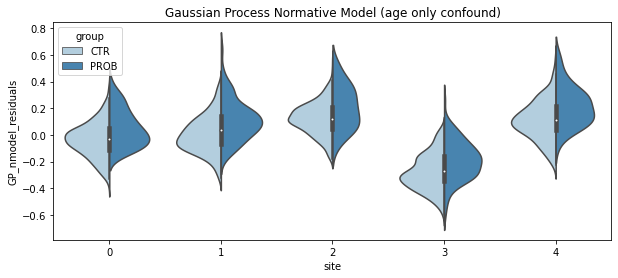

In [16]:
plt.figure(figsize=(10,4))
sns.violinplot(x='site',y='GP_nmodel_residuals',data=data_age_gp,split=True,palette='Blues',hue='group')
plt.title('Gaussian Process Normative Model (age only confound)')
plt.show()

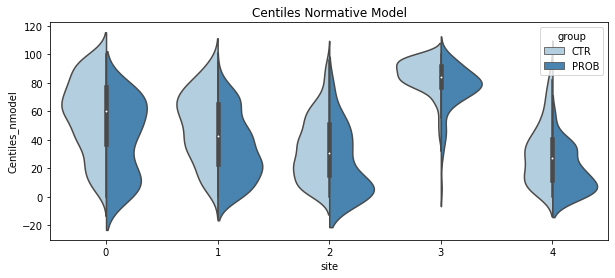

In [17]:
plt.figure(figsize=(10,4))
sns.violinplot(x='site',y='Centiles_nmodel',data=data,split=True,palette='Blues',hue='group')
plt.title('Centiles Normative Model')
plt.show()

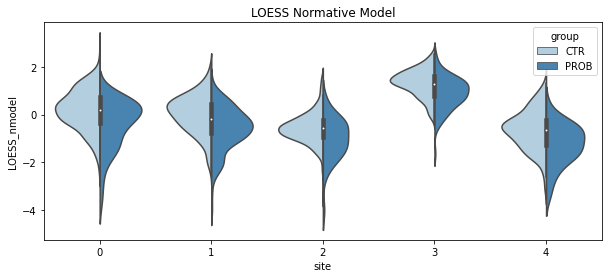

In [18]:
plt.figure(figsize=(10,4))
sns.violinplot(x='site',y='LOESS_nmodel',data=data,split=True,palette='Blues',hue='group')
plt.title('LOESS Normative Model')
plt.show()

## **Corrected scores**
Using GP model (age, sex, site confounds)

Text(0.5, 1.0, 'Corrected')

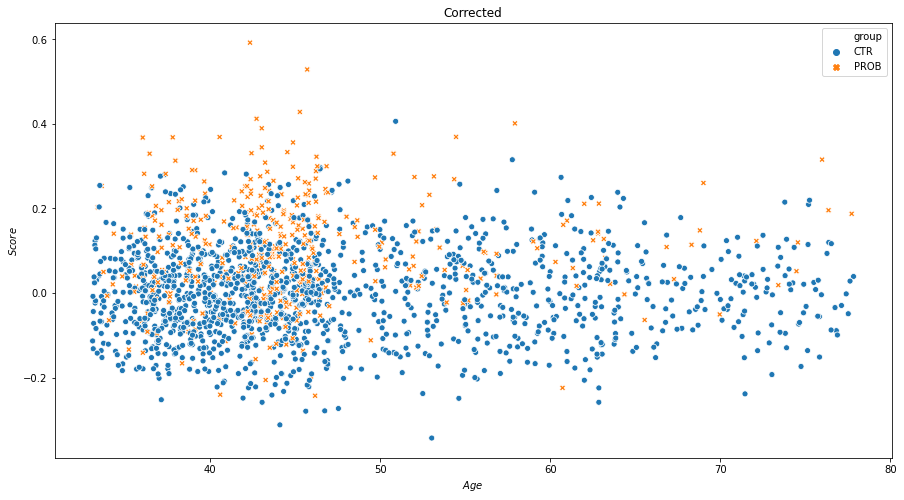

In [19]:
plt.figure(figsize=(15,8))
sns.scatterplot(data=data,x='age', y='GP_nmodel_residuals',hue='group',style='group')

plt.xlabel('$Age$')
plt.ylabel('$Score$')
plt.legend(loc='upper right')
plt.title('Corrected')

Text(0.5, 1.0, 'Uncorrected')

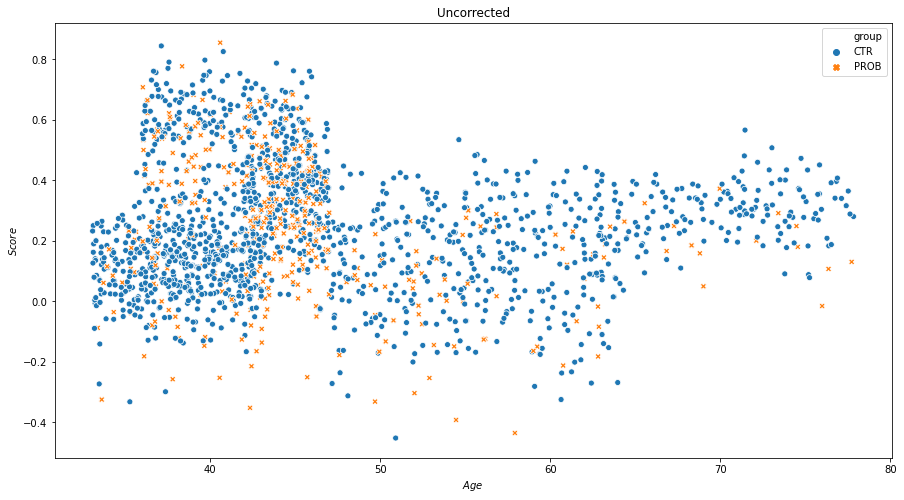

In [20]:
plt.figure(figsize=(15,8))
sns.scatterplot(data=data,x='age', y='score',hue='group',style='group')

plt.xlabel('$Age$')
plt.ylabel('$Score$')
plt.legend(loc='upper right')
plt.title('Uncorrected')

## **Case-control**
Corrected vs uncorrected scores

In [21]:
dmat = pat.dmatrix('C(group)', pynm.data, return_type='dataframe',NA_action='raise')
    
model = sm.OLS(pynm.data['score'],dmat)
results = model.fit()

print('Uncorrected')
print('p-val case-control difference: ',np.round(results.pvalues[1],4))

Uncorrected
p-val case-control difference:  0.6709


In [22]:
model = sm.OLS(pynm.data['GP_nmodel_residuals'],dmat)
results = model.fit()

print('Corrected')
print('p-val case-control difference: ',results.pvalues[1])

Corrected
p-val case-control difference:  1.911119489990013e-57


## TO DO
- Compare on two axes, site effect and proband effect